# 0. Load Modules

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating System Interaction
import os
import sys

# Machine Learning Frameworks
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader


# Model Building and Initialization
import torch.nn as nn
from torch.nn.init import kaiming_normal_

# Data Loading and Dataset Handling
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from PIL import Image
import json

# Cross-Validation and Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.special import expit as sigmoid

# Visualization and Display
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.patches as patches

from IPython.display import HTML
from astropy.visualization import ImageNormalize, SqrtStretch
import seaborn as sns
import sunpy.visualization.colormaps as cm

# Miscellaneous
import random
from tqdm import tqdm

# 1. Import data
- Image : 166x166
- Target : labels, boxes, crowd, area, id


In [2]:
class BoxDataset(Dataset):

    def __init__(self, data_dir, annot_file, mean=None, std=None, transforms=None):
        self.annot_file=annot_file
        self.transforms=transforms
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.mean = mean
        self.std = std
        self.classes = [_, "jet"] #class 0 is for background


    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        image_name= str(self.files[idx])
        image_name=image_name[:-4] #Getting the number of the event
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension, shape =(30,166,166)

        data = torch.from_numpy(data[25,:,:]).float()  # Convert to PyTorch tensor


        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        #Annotation file
        df=pd.read_csv(self.annot_file)
        df_im=df[df["id"]==int(image_name)]


        boxes=[]
        labels=[]

        boxes.extend(df_im[["x1","y1","x2","y2"]].values.tolist())
        boxes=torch.as_tensor(boxes,dtype=torch.float32)

        labels=torch.ones(len(boxes)).to(torch.int64) #Box only contain jet so labels are everytime one

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        #group the whole targets
        target={}
        target["boxes"]=boxes
        target["labels"]=labels
        target["image_id"]=torch.tensor([int(image_name)],dtype=torch.int64)
        target["area"]=area
        target["iscrowd"] = iscrowd

        return data, target

In [3]:
mean_data = 50.564544677734375
std_data = 49.94772720336914


folder1_path = './data/data separated/data1'

folder1_test_path = './data/data separated/data1_test'

folder1_valid_path = './data/data separated/data1_val'

label_dir='./data_boxes/tensor_boxes.pth'

In [4]:
total_dataset=BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")

{'boxes': tensor([[78.7377, 68.4058, 87.2623, 97.5942]]), 'labels': tensor([1]), 'image_id': tensor([92]), 'area': tensor([248.8210]), 'iscrowd': tensor([0])}
866


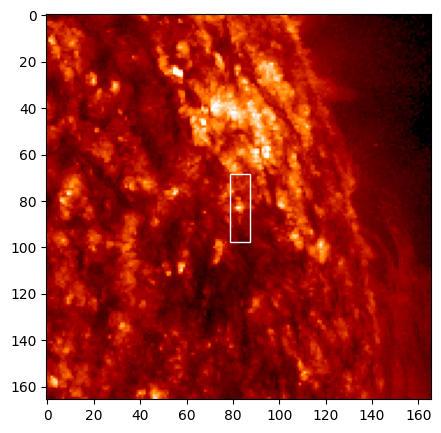

In [5]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)


    vmin, vmax = np.percentile(img, [1, 99.9])
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())


    a.imshow(img, cmap='sdoaia304', norm=norm)

    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'w',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = total_dataset[860]

print(target)
print(len(total_dataset))
plot_img_bbox(img, target)

# 2. Create Train/Test dataset
Here we use 80% train, 20% test

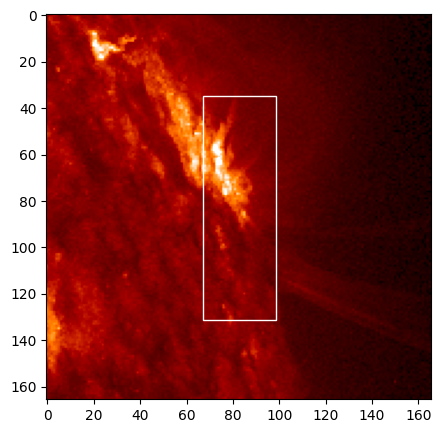

In [6]:
from utils_faster_rcnn import collate_fn
dataset = BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")
dataset_test = BoxDataset("./data/data separated/data_jet_image", mean=mean_data, std=std_data, annot_file="./data_boxes/dataframe_pandas.csv")

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

img, target=dataset[10]
plot_img_bbox(img, target)
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, collate_fn=collate_fn) 

# 3. Create Model

In [ ]:
class R2CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
       
        self.lstm = nn.LSTM(input_size=12800, hidden_size=256, num_layers=1, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(32,1),
            #nn.Sigmoid()     # don't include it as it is already included in BCELogitLoss (BCELoss is less stable)
        )

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

In [8]:
num_classes=2 #one for jet, one for background
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features, num_classes)

# 4. Train the model

In [9]:
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [10]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [11]:
from train_eval_faster_rcnn import *

In [12]:
num_epochs=10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/70]  eta: 0:05:41  lr: 0.000015  loss: 1.2147 (1.2147)  loss_classifier: 0.2491 (0.2491)  loss_box_reg: 0.0266 (0.0266)  loss_objectness: 0.9142 (0.9142)  loss_rpn_box_reg: 0.0248 (0.0248)  time: 4.8819  data: 0.1121  max mem: 7145
Epoch: [0]  [10/70]  eta: 0:02:18  lr: 0.000160  loss: 0.6811 (0.7423)  loss_classifier: 0.3295 (0.3330)  loss_box_reg: 0.0286 (0.0318)  loss_objectness: 0.3170 (0.3495)  loss_rpn_box_reg: 0.0248 (0.0281)  time: 2.3050  data: 0.1038  max mem: 7303
Epoch: [0]  [20/70]  eta: 0:02:03  lr: 0.000305  loss: 0.5525 (0.5957)  loss_classifier: 0.1784 (0.2361)  loss_box_reg: 0.0545 (0.0527)  loss_objectness: 0.1917 (0.2791)  loss_rpn_box_reg: 0.0230 (0.0278)  time: 2.3463  data: 0.1033  max mem: 7303
Epoch: [0]  [30/70]  eta: 0:01:35  lr: 0.000450  loss: 0.3868 (0.5957)  loss_classifier: 0.1059 (0.1885)  loss_box_reg: 0.0584 (0.0506)  loss_objectness: 0.1634 (0.3232)  loss_rpn_box_reg: 0.0277 (0.0333)  time: 2.4209  data: 0.1038  max mem: 7303
Epoch: [

# 5. Decode predictions

In [13]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to numpy array
def torch_to_np(img):
    return img.detach().numpy()

# 6. Testing the model

In [14]:
# pick one image from the test set
img, target = dataset_test[5]
img=torch.unsqueeze(img,0)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  53
real #boxes:  1


EXPECTED OUTPUT


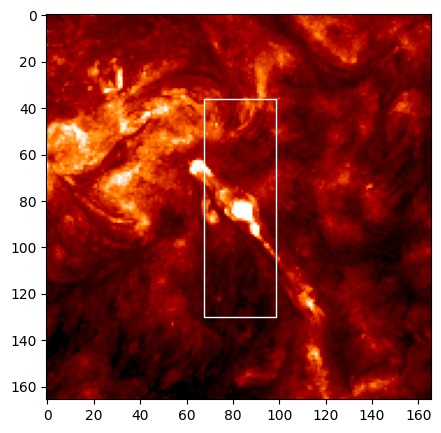

In [15]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_np(img[0,:,:]), target)

MODEL OUTPUT


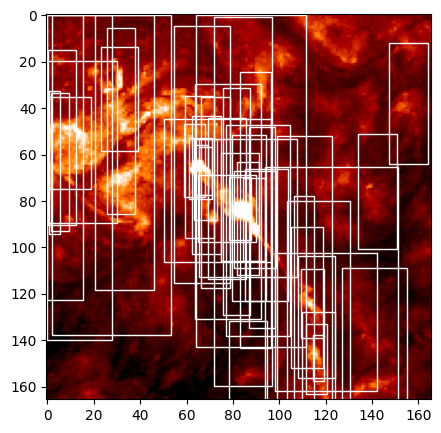

In [16]:
print('MODEL OUTPUT')
prediction={key: value.cpu() for key, value in prediction.items()}
plot_img_bbox(torch_to_np(img[0,:,:]), prediction)

NMS APPLIED MODEL OUTPUT


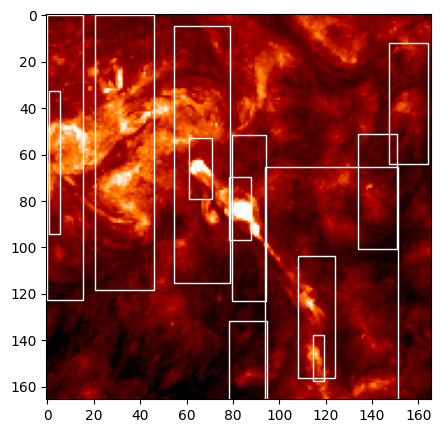

In [17]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_np(img[0,:,:]), nms_prediction)

EXPECTED OUTPUT



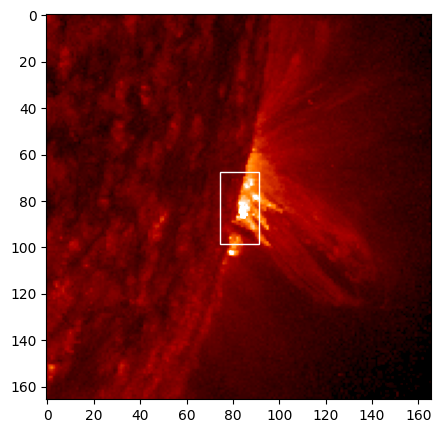

MODEL OUTPUT



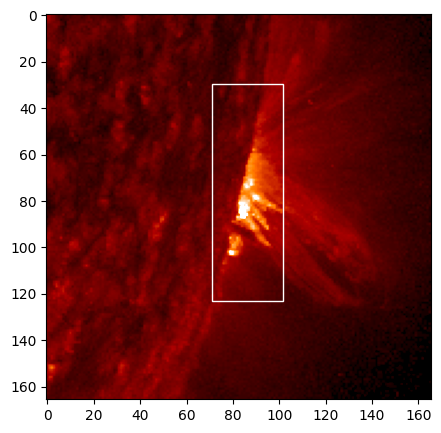

In [46]:
test_dataset = dataset_test
# pick one image from the test set
img, target = test_dataset[54] #7,9,16,17,20 incredible
img=torch.unsqueeze(img,0)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
prediction={key: value.cpu() for key, value in prediction.items()}
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_np(img[0,:,:]), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_np(img[0,:,:]), nms_prediction)

In [36]:
#torch.save(model, 'First_region_model.pth')